# Q1. Analysing ACLED Data for Nigeria in 2019

In [1]:
#make necessary imports
import numpy as np
import pandas as pd 
import pandas_bokeh
import seaborn as sns
import matplotlib.pyplot as plt
pandas_bokeh.output_notebook()
import os
import re
from datetime import timedelta
import geopy.distance
from pprint import pprint
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.util import ngrams
import string
from nltk.corpus import stopwords
stop_words = stopwords.words("english")
from wordcloud import WordCloud
from collections import Counter
%matplotlib inline

Loading BokehJS ...

In [2]:
data = pd.read_csv(r'/Users/bhargav/Desktop/Nigeria Dataset/Nigeria2019_ACLED_Extract.csv')
data.drop(columns=['iso', 'year','region','country','iso3'], inplace=True)
data['month'] = pd.DatetimeIndex(data['event_date']).month
data

data_id event_id_cnty  event_id_no_cnty event_date  time_precision  \
0     6713388      NIG15966             15966  31-Dec-19               1   
1     7784010      NIG15968             15968  31-Dec-19               1   
2     6714193      NIG15963             15963  31-Dec-19               1   
3     7784065      NIG15967             15967  31-Dec-19               1   
4     7784086      NIG15964             15964  31-Dec-19               1   
...       ...           ...               ...        ...             ...   
2211  7772844      NIG13595             13595   1-Jan-19               2   
2212  7772845      NIG13591             13591   1-Jan-19               2   
2213  7772853      NIG13590             13590   1-Jan-19               2   
2214  7772600      NIG13573             13573   1-Jan-19               1   
2215  7772602      NIG13575             13575   1-Jan-19               1   

                      event_type                       sub_event_type  \
0                       Protests                     Peaceful protest   
1     Violence against civilians                               Attack   
2                       Protests                     Peaceful protest   
3     Violence against civilians                               Attack   
4     Explosions/Remote violence                     Air/drone strike   
...                          ...                                  ...   
2211                     Battles                          Armed clash   
2212                     Battles                          Armed clash   
2213                     Battles                          Armed clash   
2214                     Battles  Non-state actor overtakes territory   
2215                     Battles  Non-state actor overtakes territory   

                                                 actor1 assoc_actor_1  inter1  \
0                                  Protesters (Nigeria)           NaN       6   
1     Boko Haram - Jamaatu Ahli is-Sunnah lid-Dawati...           NaN       2   
2                                  Protesters (Nigeria)           NaN       6   
3     Boko Haram - Jamaatu Ahli is-Sunnah lid-Dawati...           NaN       2   
4                    Military Forces of Nigeria (2015-)           NaN       1   
...                                                 ...           ...     ...   
2211                 Military Forces of Nigeria (2015-)           NaN       1   
2212                 Military Forces of Nigeria (2015-)           NaN       1   
2213                 Military Forces of Nigeria (2015-)           NaN       1   
2214                        Islamic State (West Africa)           NaN       2   
2215                        Islamic State (West Africa)           NaN       2   

      ...     location latitude  longitude  geo_precision  \
0     ...      Katsina  12.9894     7.6006              1   
1     ...      Michika  10.6159    13.3849              2   
2     ...   Ameke Ngwo   6.4390     7.4017              1   
3     ...         Kopa  10.7447    13.3325              1   
4     ...       Gujeri  11.5333    12.8167              1   
...   ...          ...      ...        ...            ...   
2211  ...      Monguno  12.6786    13.6079              1   
2212  ...      Damasak  13.0977    12.4952              1   
2213  ...  Cross Kauwa  12.9452    13.6723              1   
2214  ...          Biu  10.6129    12.1946              2   
2215  ...        Kimba  10.8167    12.4167              1   

                     source   source_scale  \
0     Daily Trust (Nigeria)       National   
1             Sun (Nigeria)       National   
2        Vanguard (Nigeria)       National   
3             Sun (Nigeria)       National   
4             Sun (Nigeria)       National   
...                     ...            ...   
2211     Vanguard (Nigeria)       National   
2212     Vanguard (Nigeria)       National   
2213     Vanguard (Nigeria)       National   
2214                    AFP  International   
2215

In [3]:
#IMPORTANT NOTE: 
#click reset button on the right side of the graph to get original view of each graph in case you zoom in to particular sections

# Fatalities due to each event in different months of 2019 in Nigeria
temp = data[['event_type', 'month', 'fatalities']]
temp = temp.groupby(['month','event_type']).sum()
temp = temp.reset_index()
temp = temp.pivot_table(index='month', columns='event_type')
temp.columns = temp.columns.droplevel(0)
temp.columns.name = None  
temp = temp.reset_index()
temp

p_stacked_hbar = temp.plot_bokeh.barh(
    x="month",
    stacked=True,
    xlabel="Fatalities",
    title="",
    alpha=0.6,
    legend = "top_right",
    show_figure=True)

In [4]:
# Fatalities due to Violence against Civilians in Nigeria in 2019 for each month

temp1 = temp.filter(items=['month','Violence against civilians'])
fatal_violance_trend = temp1.plot_bokeh.bar(
    x="month",
    stacked=False,
    xlabel="month",
    ylabel="Fatalities due to Violent Events against Civilians",
    title="Monthly Trend of Fatalities due to Violence against Civilians",
    alpha=0.6,
    legend = None,
    show_figure=True)

In [5]:
# Monthly trend of Violent acts against civilians in 2019
violence_df = data[['event_type', 'month']]
violence_df = violence_df[violence_df['event_type']=='Violence against civilians']
violence_df= violence_df.groupby('month').count()
violence_df = violence_df.rename(columns={'event_type':'Count of violent acts against civilians'})
fatal_violance_trend = violence_df.plot_bokeh.line(
    figsize=(800, 450),
    title="Monthly Trend of Violent Acts against Civilians",
    xlabel="month",
    ylabel="Number of Violent Events against Civilians",
    plot_data_points=True,
    plot_data_points_size=10,
    marker="asterisk")

In [6]:
# Violent acts against civilians comitted by each actor in 2019

va_df = data[['actor1','event_type']]
va_df= va_df[va_df['event_type']=='Violence against civilians']
va_df= va_df.groupby('actor1').count().reset_index()
va_df = va_df.sort_values('event_type',ascending=False).head(20)
va_df = va_df.rename(columns={'event_type':'Count of violent acts against civilians'})
actors_civilian_violence = va_df.plot_bokeh.bar(
    figsize=(700, 900),
    vertical_xlabel = True,
    x="actor1",
    stacked=False,
    xlabel="Actors",
    ylabel="Violent acts against Civilians",
    title="",
    alpha=0.6,
    legend = None,
    show_figure=True)

In [7]:
# Violent acts against civilians comitted at each location in 2019

lva_df = data[['location','event_type']]
lva_df= lva_df[lva_df['event_type']=='Violence against civilians']
lva_df= lva_df.groupby('location').count().reset_index()
lva_df = lva_df.sort_values('event_type',ascending=False).head(25)
lva_df = lva_df.rename(columns={'event_type':'Count of violent acts against civilians'})
actors_civilian_violence = lva_df.plot_bokeh.bar(
    figsize=(700, 450),
    vertical_xlabel = True,
    x="location",
    stacked=False,
    xlabel="Locations",
    ylabel="Violent acts against Civilians",
    title="",
    alpha=0.6,
    legend = None,
    show_figure=True)

In [8]:
#3 Months with most total lives lost. Can be further explored to understand why these months had highest fatalities? 
months = [3,4,6]
worst_months = data[data.month.isin(months)]
worst_months.filter(items=['event_date','region','admin1','admin2','admin3','fatalities','notes'])

event_date                     admin1           admin2  admin3  \
1010  30-Jun-19  Federal Capital Territory  Abuja Municipal     NaN   
1011  30-Jun-19                    Katsina          Kankara     NaN   
1012  30-Jun-19                    Zamfara            Zurmi     NaN   
1013  30-Jun-19                      Borno            Gwoza     NaN   
1014  30-Jun-19                      Borno  Maiduguri Metro     NaN   
...         ...                        ...              ...     ...   
1767   2-Mar-19                     Kaduna             Giwa     NaN   
1768   2-Mar-19                     Rivers        Akukutoru     NaN   
1769   1-Mar-19                      Lagos     Lagos Island     NaN   
1770   1-Mar-19  Federal Capital Territory  Abuja Municipal     NaN   
1771   1-Mar-19                       Ondo      Akure South     NaN   

      fatalities                                              notes  
1010           0  On 30 June 2019, supporters of the pastor that...  
1011           0  30 June (or around). Residents of Kankara barr...  
1012          10  30 June. NAF conducted airstrikes against Zamf...  
1013           2  Around 30 June 2019 (as reported), NAF encount...  
1014           0  30 June. Demonstrators in Maiduguri demonstrat...  
...          ...                                                ...  
1767           6  02 March. Unidentified gunmen invaded Sabon Sa...  
1768           0  02 March. Women in Abonnema protested the kill...  
1769           1  01 March (or around). A police officer shot a ...  
1770           0  01 March. Women protested in Abuja and appeale...  
1771           0  01 March. Unidentified gunmen attacked a SDP r...  

[577 rows x 6 columns]

## additional things to explore:

In [9]:
# 1. Mapplots of high risk locations based on time of the year (Data can be used to also make predictions on 
# event type that are more likely to occur in a certain month on certain days)

# 2. Explore correlation of event notes with fatalities of each event

# 3. Correlation of a particular location or sub region with particular event types or particular actors for e.g
# a certain froup of actors may have their activities focused in certain regions. Different combinations of 
# actors and associated actors can also have an impact on events types and event location. 


# Q2. Analysis of Newsfeed Dataframe:

In [10]:
# import newsfeed data and drop columns with single values or large number of null values

newsfeed = pd.read_csv(r'/Users/bhargav/Desktop/Nigeria Dataset/Nigeria2019_Newsfeed.csv')
newsfeed = newsfeed.drop(columns=['KPIFK', 'Newsfeed_IncidentLevel', 'Newsfeed_IncidentTypeDesc',
                                  'Newsfeed_Trajectory', 'CountryFK','Newsfeed_PeopleAffected',
                                  'Newsfeed_CountryISO','Newsfeed_Country','Newsfeed_Country_UNDPRegion'])
newsfeed

Newsfeed_PK    DateFK  Newsfeed_EventId  \
0            14127  20190111             18691   
1            14153  20190118             18720   
2            14206  20190125             18779   
3            14317  20190208             18909   
4            14428  20190215             19028   
...            ...       ...               ...   
24488      3794263  20191029          91613203   
24489      3794312  20191104          91738203   
24490      3794367  20191105          91908203   
24491      3794502  20191126          92232203   
24492      3794630  20191210          92504203   

                                 Newsfeed_Source  \
0                               Security Monitor   
1                               Security Monitor   
2                               Security Monitor   
3                               Security Monitor   
4                               Security Monitor   
...                                          ...   
24488  Intelligence Reports (Risk Advisory SIAS)   
24489  Intelligence Reports (Risk Advisory SIAS)   
24490  Intelligence Reports (Risk Advisory SIAS)   
24491  Intelligence Reports (Risk Advisory SIAS)   
24492  Intelligence Reports (Risk Advisory SIAS)   

                             Newsfeed_Source_Description  \
0      The Security Monitor is an internal UNDP monit...   
1      The Security Monitor is an internal UNDP monit...   
2      The Security Monitor is an internal UNDP monit...   
3      The Security Monitor is an internal UNDP monit...   
4      The Security Monitor is an internal UNDP monit...   
...                                                  ...   
24488  Intelligence Reports is Risk Advisory's propri...   
24489  Intelligence Reports is Risk Advisory's propri...   
24490  Intelligence Reports is Risk Advisory's propri...   
24491  Intelligence Reports is Risk Advisory's propri...   
24492  Intelligence Reports is Risk Advisory's propri...   

                                     Newsfeed_Source_Url Newsfeed_DateDisplay  \
0      https://intranet.undp.org/unit/oolts/so/Lists/...         1/11/19 5:00   
1      https://intranet.undp.org/unit/oolts/so/Lists/...         1/18/19 5:00   
2      https://intranet.undp.org/unit/oolts/so/Lists/...         1/25/19 5:00   
3      https://intranet.undp.org/unit/oolts/so/Lists/...          2/8/19 5:00   
4      https://intranet.undp.org/unit/oolts/so/Lists/...         2/15/19 5:00   
...                                                  ...                  ...   
24488                                                NaN        10/29/19 0:00   
24489                                                NaN         11/4/19 0:00   
24490                                                NaN         11/5/19 0:00   
24491                                                NaN        11/26/19 0:00   
24492                                                NaN        12/10/19 0:00   

      Newsfeed_IncidentType  \
0            Armed Conflict   
1            Armed Conflict   
2            Armed Conflict   
3            Armed Conflict   
4            Armed Conflict   
...                     ...   
24488                   NaN   
24489                   NaN   
24490                   NaN   
24491                   NaN   
24492                   NaN   

                                    Newsfeed_Description  \
0      ARMED CONFLICT On 09 January 2019, at about 22...   
1      ARMED CONFLICTOn 16 January 2019, 1230hours, B...   
2      ARMED CONFLICTOn 25 January 2019 at about 0400...   
3      ARMED CONFLICTOn 07 February 2019 at about 183...   
4      ARMED CONFLICTOn 12 February 2019 at about 180...   
...                                                  ...   
24488  West & Central Africa | Intelligence Summary |...   
24489  Nigeria | Frequency of attacks increasing in n...   
24490  West & Central Africa | Intelligence Summary |...   
24491  West & Central Africa | Intelligence Summary |...   
24492  West & Central Africa | Intelligence Summary |.

In [11]:
# Data Cleaning Function
ps = PorterStemmer()

# add the word size to the stopword
def get_clean_text(x):
    
    x = x.lower()
    x = ' '.join([word for word in x.split(' ') if word not in stop_words])
    x = x.encode('ascii', 'ignore').decode()
    x = re.sub(r'https*\S+', ' ', x)
    x = re.sub(r'@\S+', ' ', x)
    x = re.sub(r'#\S+', ' ', x)
    x = re.sub(r'\'\w+', '', x)
    x = re.sub('[%s]' % re.escape(string.punctuation), ' ', x)
    x = re.sub(r'\w*\d+\w*', '', x)
    x = re.sub(r'\s{2,}', ' ', x)

    x = ' '.join([ps.stem(word) for word in x.split(' ')])
    return x

In [12]:
# Function to plot ngrams
def plot_ngrams(text, n=2, topk=15):

    text = get_clean_text(text)
    tokens = text.split()
    
    # get the ngrams 
    ngram_phrases = ngrams(tokens, n)
    
    # Get the most common ones 
    most_common = Counter(ngram_phrases).most_common(topk)
    
    # Make word and count lists 
    words, counts = [], []
    for phrase, count in most_common:
        word = ' '.join(phrase)
        words.append(word)
        counts.append(count)
    
    # Plot the barplot 
    plt.figure(figsize=(10, 6))
    title = "Most Common " + str(n) + "-grams in the text"
    plt.title(title)
    ax = plt.bar(words, counts)
    plt.xlabel("n-grams found in the text")
    plt.ylabel("Ngram frequencies")
    plt.xticks(rotation=90)
    plt.show()
    
# Function to collect all the text 
def get_text(df, column):
    text = ''
    
    # iterate through the data 
    for i in range(df.shape[0]):
        text += df.iloc[i][column] 
        text += ' '
    
    return text

In [13]:
newsfeed['Newsfeed_IncidentType'].unique()

array(['Armed Conflict', 'Governance', 'Conflict', 'Displacement',
       'Human Development', 'UNDP_Conflict', 'UNDP_TerroristAttack',
       'UNDP_Security', 'UNDP_Society', 'UNDP_Ecology',
       'UNDP_PoliticalUnrest', 'UNDP_Drought', 'UNDP_NaturalDisasters',
       'UNDP_ManMadeDisasters', 'UNDP_ScienceandTechnology',
       'UNDP_HumanitarianAid', 'UNDP_Genocide', 'UNDP_WaterConflict', nan],
      dtype=object)

In [14]:
# Collect all the text 
all_short_description = get_text(newsfeed, 'Newsfeed_Description')
all_long_description = get_text(newsfeed, 'Newsfeed_Description2')
len(all_short_description), len(all_long_description)

(1600231, 8034152)

In [15]:
# Clean the long description 
clean_long_text = get_clean_text(all_long_description)
clean_long_text

'arm conflict januari inform reveal bh reportedli attack secur forc locat vicin bulabulin villag konduga lga borno state engag secur personnel exchang gunfir attack repel secur forc reinforc damboa town damboa lga naf close air support arriv area thenumb casualti unknown on januari unknown time report indic secur forc conduct clearanc oper cross kauwa baga doron baga villag kukawa lga borno state troop reportedli neutralis unknown number bh iswap member rescu unknown number civilian trap baga doron baga villag casualti figur oper report on januari report receiv sourc indic bh conduct incurs near ngauramari gana villag konduga lga borno state engag secur personnel exchang gunfir attack reportedli repel theattack withdrew unknown locat number casualti unknown januari accord inform receiv bh reportedli attack secur forc deploy area auno villag kaga lga borno state engag secur personnel exchang gunfir subsequ attack repel immedi securityforc close air support ca attend scene engag attack f

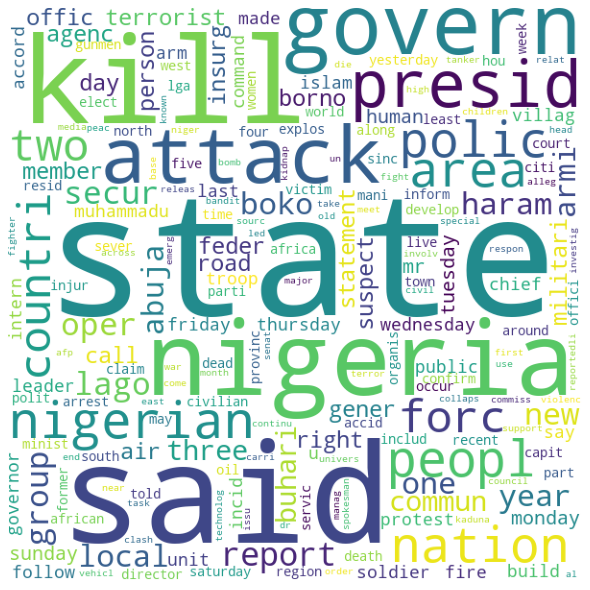

In [16]:
# Let's make a word cloud to see the most popular words in the text 
word_cloud = WordCloud(collocations=False, 
                       width=600, 
                       height=600,
                       background_color = 'white').generate(clean_long_text)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(word_cloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

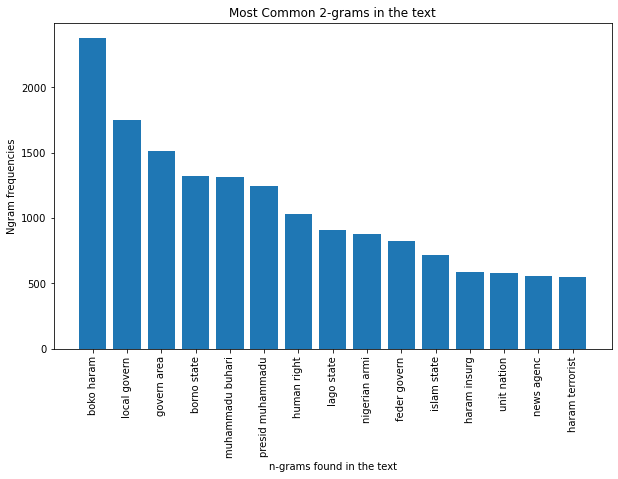

In [17]:
# Let's look at the most common words 
plot_ngrams(clean_long_text, n=2, topk=15)

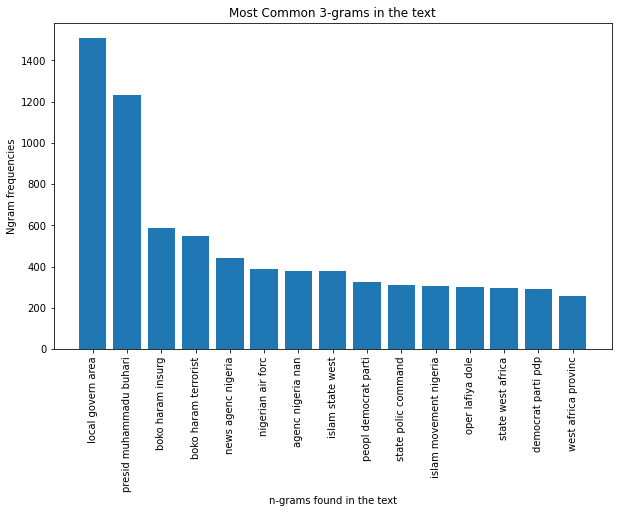

In [18]:
# Let's look at the most common words 
plot_ngrams(clean_long_text, n=3, topk=15)

In [19]:
# Drop the null values in the incident type column 
newsfeed_copy = newsfeed.copy()
newsfeed.dropna(subset=['Newsfeed_IncidentType'], inplace=True)

In [20]:
# Assigning and individual id to each event type
newsfeed['incident_id'] = newsfeed['Newsfeed_IncidentType'].factorize()[0]
incident_category = newsfeed[['Newsfeed_IncidentType', 'incident_id']].drop_duplicates().sort_values('incident_id')
incident_category

Newsfeed_IncidentType  incident_id
0                Armed Conflict            0
30                   Governance            1
31                     Conflict            2
35                 Displacement            3
43            Human Development            4
51                UNDP_Conflict            5
53         UNDP_TerroristAttack            6
54                UNDP_Security            7
56                 UNDP_Society            8
60                 UNDP_Ecology            9
61         UNDP_PoliticalUnrest           10
69                 UNDP_Drought           11
70        UNDP_NaturalDisasters           12
95        UNDP_ManMadeDisasters           13
160   UNDP_ScienceandTechnology           14
254        UNDP_HumanitarianAid           15
343               UNDP_Genocide           16
1925         UNDP_WaterConflict           17

In [21]:
# Convert into a label dictionary 
category_labels = dict(incident_category.values)
print(category_labels)

print("======="*15) # Line break display

# Similarly, we can create an inverse of the previous one to convert labels to categories
category_reverse = dict(incident_category[['incident_id', 'Newsfeed_IncidentType']].values)
print(category_reverse)

{'Armed Conflict': 0, 'Governance': 1, 'Conflict': 2, 'Displacement': 3, 'Human Development': 4, 'UNDP_Conflict': 5, 'UNDP_TerroristAttack': 6, 'UNDP_Security': 7, 'UNDP_Society': 8, 'UNDP_Ecology': 9, 'UNDP_PoliticalUnrest': 10, 'UNDP_Drought': 11, 'UNDP_NaturalDisasters': 12, 'UNDP_ManMadeDisasters': 13, 'UNDP_ScienceandTechnology': 14, 'UNDP_HumanitarianAid': 15, 'UNDP_Genocide': 16, 'UNDP_WaterConflict': 17}
{0: 'Armed Conflict', 1: 'Governance', 2: 'Conflict', 3: 'Displacement', 4: 'Human Development', 5: 'UNDP_Conflict', 6: 'UNDP_TerroristAttack', 7: 'UNDP_Security', 8: 'UNDP_Society', 9: 'UNDP_Ecology', 10: 'UNDP_PoliticalUnrest', 11: 'UNDP_Drought', 12: 'UNDP_NaturalDisasters', 13: 'UNDP_ManMadeDisasters', 14: 'UNDP_ScienceandTechnology', 15: 'UNDP_HumanitarianAid', 16: 'UNDP_Genocide', 17: 'UNDP_WaterConflict'}


In [22]:
# Apply the clean text function on the the descriptions
newsfeed['clean_desc'] = newsfeed['Newsfeed_Description'].apply(get_clean_text)
newsfeed['clean_desc']

0        arm conflict januari inform reveal bh reported...
1        arm conflicton januari boko haram element repo...
2        arm conflicton januari inform receiv confirm b...
3        arm conflicton februari hour boko haram attack...
4        arm conflicton februari sourc indic bh gun tru...
                               ...                        
24417       mob set truck ablaz kill two motorcyclist ogun
24418       panel blame fire explos river commun oil thiev
24419    alert iswap plan abduct travel benishiek maino...
24420            deadliest year colombia ex farc combat un
24421            polic arrest suspect crimin katsina state
Name: clean_desc, Length: 24422, dtype: object

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Creating an instance of the Tfidf vectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, 
                        min_df=5, 
                        norm = 'l2', 
                        encoding='latin-1', 
                        ngram_range=(1, 2))


# Extracting the features by fitting the Vectorizer on Combined Data
feat = tfidf.fit_transform(newsfeed['clean_desc']).toarray()
labels = newsfeed['incident_id']    # Series containing all the post labels

In [24]:
# Finding out what description category  correlates to which ngrams

from sklearn.feature_selection import chi2

# chisq2 statistical test
N = 5    # Number of examples to be listed
for f, i in sorted(category_labels.items()):
    chi2_feat = chi2(feat, labels == i)
    indices = np.argsort(chi2_feat[0])
    feat_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [w for w in feat_names if len(w.split(' ')) == 1]
    bigrams = [w for w in feat_names if len(w.split(' ')) == 2]
    print("\nDescription Category '{}':".format(f))
    print("Most correlated unigrams:\n\t. {}".format('\n\t. '.join(unigrams[-N:])))
    print("Most correlated bigrams:\n\t. {}".format('\n\t. '.join(bigrams[-N:])))


Description Category 'Armed Conflict':
Most correlated unigrams:
	. arm
	. inform
	. indic
	. bh
	. conflicton
Most correlated bigrams:
	. secur forc
	. conflict octob
	. inform receiv
	. arm conflict
	. arm conflicton

Description Category 'Conflict':
Most correlated unigrams:
	. attent
	. rapporteur
	. requir
	. weak
	. northwestern
Most correlated bigrams:
	. west africa
	. haram crisi
	. state west
	. africa provinc
	. anti boko

Description Category 'Displacement':
Most correlated unigrams:
	. displac
	. escal
	. northeast
	. intensifi
	. devast
Most correlated bigrams:
	. haram attack
	. north east
	. thousand flee
	. northeast nigeria
	. flee north

Description Category 'Governance':
Most correlated unigrams:
	. crackdown
	. race
	. intensifi
	. overturn
	. inspect
Most correlated bigrams:
	. nigeria elect
	. media bill
	. main opposit
	. nigeria buhari
	. nigeria presid

Description Category 'Human Development':
Most correlated unigrams:
	. risk
	. humanitarian
	. rice
	. fuel

## News Sources and News Incident Type it reports most often

In [25]:
source_forte = newsfeed_copy[['Newsfeed_Source','Newsfeed_IncidentType']]
source_forte['COUNTER'] =1       #initially, set that counter to 1.
source_forte = source_forte.groupby(['Newsfeed_Source','Newsfeed_IncidentType'])['COUNTER'].sum().to_frame() #sum function
source_forte

<ipython-input-25-3dc9b30d1315>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  source_forte['COUNTER'] =1       #initially, set that counter to 1.


COUNTER
Newsfeed_Source  Newsfeed_IncidentType             
EMM              UNDP_Conflict                 4687
                 UNDP_Drought                   177
                 UNDP_Ecology                   406
                 UNDP_Genocide                  307
                 UNDP_HumanitarianAid            42
                 UNDP_ManMadeDisasters         3623
                 UNDP_NaturalDisasters          539
                 UNDP_PoliticalUnrest           250
                 UNDP_ScienceandTechnology     2006
                 UNDP_Security                 3461
                 UNDP_Society                  2500
                 UNDP_TerroristAttack          6346
                 UNDP_WaterConflict              27
OnWatch          Conflict                         8
                 Displacement                     2
                 Governance                       8
                 Human Development                3
Security Monitor Armed Conflict                  30


## Thank you for reading my code!